# Approximate Factor Models, Vector Autoregression and Temporal Convolutional Networks from FRED-MD

Extract an approximate factor structure that reduces the number of dimensions (variables) in a large set of economic time series (FRED-MD), with number of components automatically selected by an information criterion and outliers replaced with an EM approach. 

Contrast Vector Autoregression and Temporal Convolutional Networks to model the time-series persistance of the extracted factors, and compare prediction errors.

- PCA, EM, vector autoregression, temporal convolutional networks
- Bai and Ng (2002), McCracken and Ng (2016), and others

Terence Lim

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import os
import re
import time
from datetime import datetime
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from finds.alfred import Alfred, fred_md, fred_qd
from finds.alfred import pcaEM, BaiNg, marginalR2
from finds.solve import integration_order, is_inlier
from finds.display import plot_bands

from settings import settings
imgdir = os.path.join(settings['images'], 'ts')
alf = Alfred(api_key=settings['fred']['api_key'])

## Load FRED-MD and FRED-QD
- test stationarity after applying transform codes

In [4]:
# Transformation Codes, and Stationarity
qdf, qt = fred_qd(202004) # 202004      # from vintage April 2020
mdf, mt = fred_md(201505) # 201505

print('Number of time series and suggested transformations, by tcode:')
tcodes = pd.concat([Series(alf.tcode_[i], name=i).to_frame().T
                    for i in range(1,8)], axis=0).fillna(False)
tcodes = tcodes.join(qt['transform'].value_counts().rename('fred-qd'))\
               .join(mt['transform'].value_counts().rename('fred-md'))\
               .fillna(0).astype({'fred-qd': int, 'fred-md': int})

# Estimate and Compare Integration Order
out = {}
for label, df, t in [['md', mdf, mt], ['qd', qdf, qt]]:
    stationary = dict()
    for series_id, tcode in t['transform'].items():
        if tcode in [1, 2, 3, 4, 5, 6]:
            s = df[series_id] if tcode <= 3 else np.log(df[series_id])
            order = integration_order(s.dropna(), pvalue=0.05)
            stationary[series_id] = {
                'tcode': tcode,
                'I(p)': order,
                'different': '*' if (tcode - 1) % 3 != order else '',
                'title': alf.header(series_id)}
            #print(series_id, order, tcode)
    stationary = DataFrame.from_dict(stationary, orient='index')
    stationary = stationary.sort_values(stationary.columns.to_list())
    c = stationary.groupby(['tcode','I(p)'])['title'].count().reset_index()
    out[label] = c.pivot(index='tcode', columns='I(p)',
                         values='title').fillna(0).astype(int)
    out[label].columns=[f"I({p})" for p in out[label].columns]
print('Series by tcode, transformations and estimated order of integration:')
c = pd.concat([tcodes.drop(columns='fred-md'), out['qd'], tcodes['fred-md'],
    	       out['md']], axis=1).fillna(0).astype(int)
c

Number of time series and suggested transformations, by tcode:
Series by tcode, transformations and estimated order of integration:


,diff,log,pct_change,fred-qd,I(0),I(1),I(2),fred-md,I(0),I(1),I(2)
1,0,0,0,22,15,7,0,17,17,0,0
2,1,0,0,32,7,24,1,19,5,14,0
3,2,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,10,6,4,0
5,1,1,0,143,33,105,5,53,8,45,0
6,2,1,0,50,0,23,27,34,0,23,11
7,1,0,1,1,0,0,0,1,0,0,0


## PCA-EM Algorithm for Approximate Factors Model

- Extract approximate factor, with outliers and removed replaced through an EM approach. 
- Show auto-selected number of factors, and more correlated series to each factor, for FRED-MD and FRED-QD
- Bai and Ng (2002)

In [5]:
for freq, df, t in [['monthly', mdf, mt], ['quarterly', qdf, qt]]:
    df = qdf.copy()
    t = qt['transform']

    # Apply tcode transformations
    transformed = []
    for col in df.columns:
        transformed.append(alf.transform(df[col], tcode=t[col], freq=freq[0]))
    data = pd.concat(transformed, axis=1).iloc[2:]
    cols = list(data.columns)
    sample = data.index[((np.count_nonzero(np.isnan(data), axis=1)==0) |
                         (data.index <= 20141231)) & (data.index >= 19600301)]

    # set missing and outliers in X to NaN
    X = np.array(data.loc[sample])
    X[~is_inlier(X, method='iq10')] = np.nan

    # compute PCA EM and auto select number of components, r
    x, model = pcaEM(X, kmax=None, p=2, tol=1e-21, echo=False)
    r = BaiNg(x, p=2, standardize=True)

    # show marginal R2's of series to each component
    mR2 = marginalR2(x, standardize=True)
    print(f"FRED-{freq[0].upper()}D {freq} series:")
    print(f"Explained by {r} factors: {np.sum(np.mean(mR2[:r,:], axis=1)):.3f}"
          f" ({len(x)} obs: {min(sample)}-{max(sample)})")
    for k in range(r):
        print()
        print(f"Factor:{1+k:2d}  Variance Explained={np.mean(mR2[k, :]):6.3f}")
        args = np.argsort(-mR2[k, :])
        for i, arg in enumerate(args[:10]):
            print(f"{mR2[k, arg]:6.3f} {cols[arg]:16s} {alf.header(cols[arg])}")


FRED-MD monthly series:
Explained by 7 factors: 0.498 (240 obs: 19600331-20191231)

Factor: 1  Variance Explained= 0.201
 0.838 USPRIV           All Employees, Total Private
 0.818 USGOOD           All Employees, Goods-Producing
 0.817 OUTMS            Manufacturing Sector: Real Output
 0.812 PAYEMS           All Employees, Total Nonfarm
 0.812 IPMANSICS        Industrial Production: Manufacturing (SIC)
 0.806 INDPRO           Industrial Production: Total Index
 0.776 MANEMP           All Employees, Manufacturing
 0.772 HOANBS           Nonfarm Business Sector: Hours of All Persons
 0.767 DMANEMP          All Employees, Durable Goods
 0.764 UNRATE           Unemployment Rate

Factor: 2  Variance Explained= 0.082
 0.500 AAAFFM           Moody's Seasoned Aaa Corporate Bond Minus Federal Funds Rate
 0.476 T5YFFM           5-Year Treasury Constant Maturity Minus Federal Funds Rate
 0.461 PERMIT           New Privately-Owned Housing Units Authorized in Permit-Issuing Places: Total Units
 0.

 0.229 NWPI             *** NWPI ***
 0.226 USSERV           All Employees, Other Services
 0.214 COMPRMS          Manufacturing Sector: Real Compensation Per Hour

Factor: 5  Variance Explained= 0.038
 0.358 OPHMFG           Manufacturing Sector: Real Output Per Hour of All Persons
 0.304 HWI              Help Wanted Index for United States
 0.291 NWPI             *** NWPI ***
 0.289 AWHMAN           Average Weekly Hours of Production and Nonsupervisory Employees, Manufacturing
 0.262 OPHPBS           Business Sector: Real Output Per Hour of All Persons
 0.233 UNRATELT         *** UNRATELT ***
 0.228 OPHNFB           Nonfarm Business Sector: Real Output Per Hour of All Persons
 0.218 UNLPNBS          Nonfarm Business Sector: Unit Nonlabor Payments
 0.215 ULCMFG           Manufacturing Sector: Unit Labor Cost
 0.193 TLBSNNCBBDI      *** TLBSNNCBBDI ***

Factor: 6  Variance Explained= 0.030
 0.264 CONSPI           Nonrevolving consumer credit to Personal Income
 0.242 ULCBS            B

## Extract factors

In [7]:
# pipe.fit through 20141231, pipe.transform through 20201231
df, t = fred_md(202104) # 201505
sample_date = 20141231
data = []
for col in df.columns:
    data.append(alf.transform(df[col], tcode=t['transform'][col], freq='m'))
data = pd.concat(data, axis=1).iloc[2:]
cols = list(data.columns)
sample = data.index[((np.count_nonzero(np.isnan(data), axis=1)==0) |
                     (data.index <= sample_date)) & (data.index >= 19600301)]
train_sample = sample[sample <= sample_date]
test_sample = sample[sample <= 20191231]

# replace missing and outliers with PCA EM and fixed number of components r=8
r = 8
X = np.array(data.loc[train_sample])
X[~is_inlier(X, method='iq10')] = np.nan
x, model = pcaEM(X, kmax=r, p=0, echo=False)

# Extract factors with SVD
y = ((x-x.mean(axis=0).reshape(1,-1))/x.std(axis=0,ddof=0).reshape(1,-1))
u, s, vT = np.linalg.svd(y, full_matrices=False)
#factors = DataFrame(u[:, :r], columns=np.arange(1, 1+r),
#                    index=pd.DatetimeIndex(train_sample.astype(str), freq='M'))
Series(s[:r]**2 / np.sum(s**2), index=np.arange(1, r+1), name='R2').to_frame().T


,1,2,3,4,5,6,7,8
R2,0.149606,0.071396,0.06826,0.057014,0.043102,0.033687,0.031621,0.027009


## Equivalently with sklearn PCA

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(r))])
pipe.fit(x)                        # fit model on training data
X = np.array(data.loc[sample])     # to transform on full sample data
X, model = pcaEM(X, kmax=8, p=0, echo=False)  # replace missing (not outlier)
factors = DataFrame(StandardScaler().fit_transform(pipe.transform(X)),
                    index=pd.DatetimeIndex(sample.astype(str), freq='infer'),
                    columns=np.arange(1, 1+r))
Series(pipe.named_steps['pca'].explained_variance_ratio_,
       index=np.arange(1,r+1), name='R2').to_frame().T   # sanity check

,1,2,3,4,5,6,7,8
R2,0.149606,0.071396,0.06826,0.057014,0.043102,0.033687,0.031621,0.027008


## Retrieve recession periods from FRED

In [9]:
usrec = alf('USREC', freq='m')  
usrec.index = pd.DatetimeIndex(usrec.index.astype(str), freq='infer')
g = usrec.astype(bool) | usrec.shift(-1, fill_value=0).astype(bool)
g = (g != g.shift(fill_value=0)).cumsum()[g].to_frame()
g = g.reset_index().groupby('USREC')['date'].agg(['first','last'])
vspans = [(v[0], v[1]) for k, v in g.iterrows()]
print(alf.header('USREC'))
DataFrame(vspans, columns=['Start', 'End'])

NBER based Recession Indicators for the United States from the Period following the Peak through the Trough


,Start,End
0,1854-12-31,1854-12-31
1,1857-06-30,1858-12-31
2,1860-10-31,1861-06-30
3,1865-04-30,1867-12-31
4,1869-06-30,1870-12-31
5,1873-10-31,1879-03-31
6,1882-03-31,1885-05-31
7,1887-03-31,1888-04-30
8,1890-07-31,1891-05-31
9,1893-01-31,1894-06-30


## Plot extracted factors alongside recession periods

Look visually how extracts performed in recessionary or other time periods

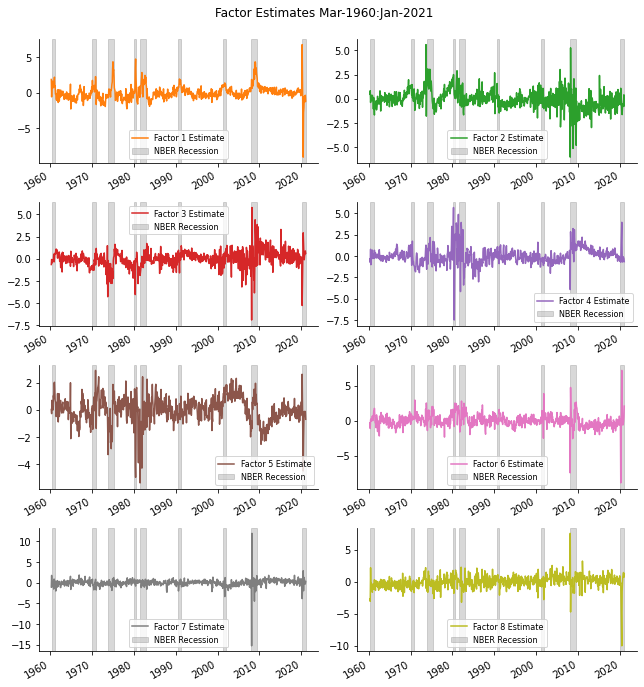

In [10]:
fig = plt.figure(figsize=(9, 10), num=1, clear=True)
for col in factors.columns:
    ax = fig.add_subplot(4, 2, col)
    flip = -np.sign(max(factors[col]) + min(factors[col])) # try match sign
    (flip*factors[col]).plot(ax=ax, color=f"C{col}")
    for a,b in vspans:
        if b >= min(factors.index):
            ax.axvspan(max(a, min(factors.index)), min(b, max(factors.index)),
                       alpha=0.3, color='grey')
    ax.legend([f"Factor {col} Estimate", 'NBER Recession'], fontsize=8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"Factor Estimates {factors.index[0]:%b-%Y}:"
             f"{factors.index[-1]:%b-%Y}", fontsize=12)
plt.savefig(os.path.join(imgdir, 'approximate.jpg'))
plt.show()

# Vector Autoregression Model of the Extracted Factors

predicting composites of, rather than individual, macroeconomic time series

In [11]:
maxlags = 16
train_date = '2014-12-31'
train_index = factors.index[factors.index <= train_date]
test1_index = factors.index[(factors.index >= train_index[-maxlags]) &
                            (factors.index <= '2019-12-31')]
test2_index = factors.index[(factors.index >= test1_index[-maxlags])]
train_data = factors.loc[train_index].copy()
test1_data = factors.loc[test1_index].copy()
test2_data = factors.loc[test2_index].copy()
M = train_data.shape[1]
model = VAR(train_data, freq='M')

## Selecting lag order

With different information criteria

In [12]:
results = {p: model.fit(p) for p in range(1, maxlags+1)}   # VAR(p) models
DataFrame({ic: model.fit(maxlags=maxlags, ic=ic).k_ar
           for ic in ['aic', 'fpe', 'hqic', 'bic']},
          index=['lag order selected by:'])\
          .rename_axis(columns='Information Criterion:')

Information Criterion:,aic,fpe,hqic,bic
lag order selected by:,9,9,3,2


## Extract and plot impulse response function with confidence bands

The lagged coefficients estimated from the Vector Autoregression produce a multi-period cumulative forecast

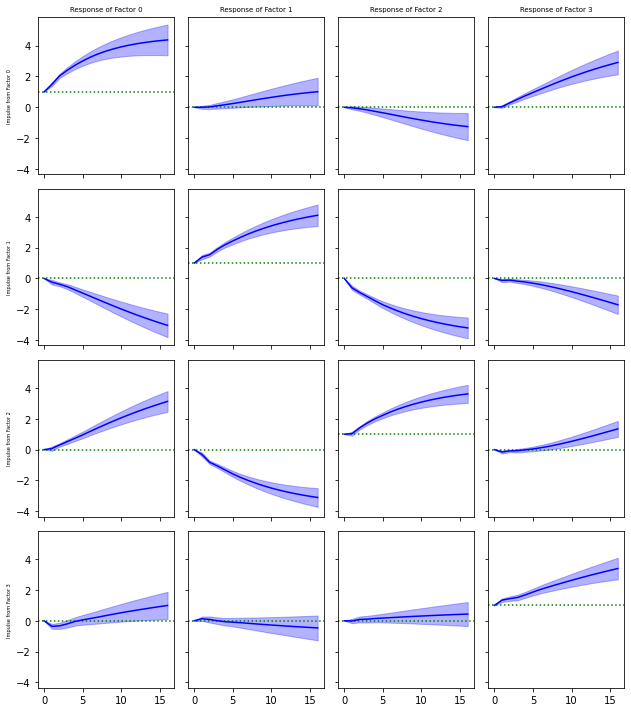

In [13]:
irf = results[2].irf(maxlags)
m = 4  #M
fig, axes = plt.subplots(m, m, figsize=(9,10), num=1, clear=True,
                         sharex=True, sharey=True)
for impulse in range(m):
    for response in range(m):
        plot_bands(mean=irf.cum_effects[:, impulse, response],
                   stderr=irf.cum_effect_stderr()[:, impulse, response],
                   hline=1 if impulse == response else 0,
                   title=None if impulse else f"Response of Factor {response}",
                   ylabel=None if response else f"Impulse from Factor {impulse}",
                   fontsize=3, ax=axes[impulse, response])
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'impulse.jpg'))
plt.show()

## Collect one-period ahead forecasts and errors in train and test sets


In [14]:
from sklearn.metrics import mean_squared_error as mse
mean_error = dict()
var_error= {p: dict() for p in results}
for x in [train_data, test1_data, test2_data]:
    for i in range(maxlags, len(x)):
        # error of unconditional mean forecast
        mean_error[x.index[i]] = mse(x.iloc[i].values, train_data.mean().values)
        
        # error VAR(p) model forecasts
        for p in var_error:
            pred = results[p].forecast(x.iloc[(i-p):i].values, 1)
            var_error[p][x.index[i]] = mse([x.iloc[i].values], pred)

## Compute mean test and train set errors of all models

Unsurprisingly, lower training errors with greater lag orders, but test error minimized around p=2

In [15]:
errors = {0: Series(mean_error, name="TrainSampleMean")}  # VAR(0)
errors.update({p: Series(var_error[p], name=f"VAR({p})") for p in var_error})

out = [Series({'Train Error': e.loc[e.index <= train_date].mean(),
               'Test1 Error': e.loc[test1_index].mean(),
               'Test2 Error': e.loc[test2_index].mean()},
              name=e.name) for p, e in errors.items()]
out = pd.concat(out, axis=1).T.rename_axis(columns="1961-07-31...2019-12-31:")
out


1961-07-31...2019-12-31:,Train Error,Test1 Error,Test2 Error
TrainSampleMean,0.971111,0.440971,2.676766
VAR(1),0.654597,0.330116,2.852927
VAR(2),0.609062,0.308772,2.902876
VAR(3),0.585084,0.303305,3.033507
VAR(4),0.567812,0.301222,3.132501
VAR(5),0.551640,0.301965,3.284912
VAR(6),0.537280,0.302687,3.332382
VAR(7),0.520813,0.307726,3.348354
VAR(8),0.507601,0.302543,3.336819
VAR(9),0.492229,0.307823,3.311064


## Plot Train and Test Error of  VAR(p) Models

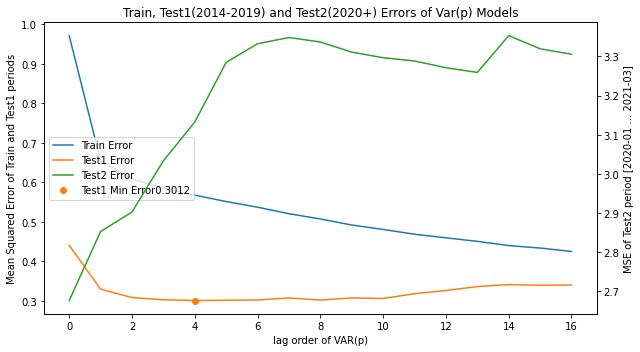

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
ax.plot(np.arange(len(out)), out['Train Error'], color=f"C0")
ax.plot(np.arange(len(out)), out['Test1 Error'], color=f"C1")
ax.plot([], [], color=f"C2")   # dummy for legend labels
argmin = out['Test1 Error'].argmin()
ax.plot(argmin, out.iloc[argmin]['Test1 Error'], 'o', color="C1")
bx = ax.twinx()
bx.plot(np.arange(len(out)), out['Test2 Error'], color=f"C2")
ax.set_title(f'Train, Test1(2014-2019) and Test2(2020+) Errors of Var(p) Models')
ax.set_ylabel('Mean Squared Error of Train and Test1 periods')
bx.set_ylabel('MSE of Test2 period [2020-01 ... 2021-03]')
ax.set_xlabel('lag order of VAR(p)')
ax.legend(['Train Error', 'Test1 Error', 'Test2 Error',
           f'Test1 Min Error{out.iloc[argmin]["Test1 Error"]:.4f}'],
          loc='center left')
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'varerr.jpg'))
plt.show()


## Plot monthly mean squared error

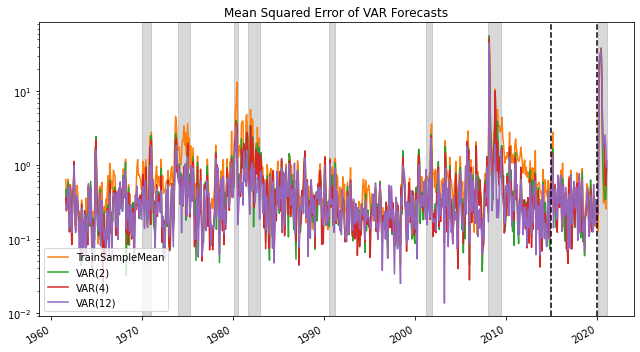

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
ax.set_yscale('log')
for i, p in enumerate([0, 2, 4, 12]):
    errors[p].plot(ax=ax, c=f'C{i+1}', style='-')
for a,b in vspans:
    if b >= min(errors[0].index):
        ax.axvspan(max(a, min(errors[0].index)), min(b, max(errors[0].index)),
                   alpha=0.3, color='grey')
ax.set_title('Mean Squared Error of VAR Forecasts')
ax.axvline(max(train_index), color='black', linestyle='--')
ax.axvline(max(test1_index), color='black', linestyle='--')
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'varmse.jpg'))
plt.show()

# Temporal 1D Convolutional Net (TCN)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TCN(torch.nn.Module):
    class CausalConv1dBlock(torch.nn.Module):
        """Conv1d block with ReLU, skip, dropout, dilation and padding"""
        def __init__(self, in_channels, out_channels, kernel_size, dilation,
                     dropout):
            super().__init__()

            print('kernel', kernel_size, 'dilation', dilation)
            self.network = torch.nn.Sequential(
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(in_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(out_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout))
            self.skip = lambda x: x
            if in_channels != out_channels:   # downsample for skip if necessary
                self.skip = torch.nn.Conv1d(in_channels, out_channels, 1)

        def forward(self, x):
            return self.network(x) + self.skip(x)  # with skip connection


    def __init__(self, n_features, blocks, kernel_size, dropout):
        """TCN model by connecting multiple convolution layers"""
        super().__init__()
        in_channels = n_features
        L = []
        for dilation, hidden in enumerate(blocks):
            L.append(self.CausalConv1dBlock(in_channels=in_channels,
                                            out_channels=hidden,
                                            kernel_size=kernel_size,
                                            dilation=2**dilation,
                                            dropout=dropout))
            in_channels = hidden
        self.network = torch.nn.Sequential(*L) if L else lambda x: x
        if L:
            self.classifier = torch.nn.Conv1d(in_channels, n_features, 1)
        else:
            self.classifier = torch.nn.Sequential(
                torch.nn.ConstantPad1d((kernel_size-1, 0), 0),                
                torch.nn.Conv1d(in_channels, n_features, kernel_size))

    def forward(self, x):
        """input is (B, n_features, L)), linear expects (B, * n_features)"""
        return self.classifier(self.network(x))

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self



## Create input data from training set

In [19]:
seq_len = 16    # length of each input sequence for TCN
train_exs = [train_data.iloc[i-(seq_len+1):i].values
             for i in range(seq_len+1, len(train_data))]


## Fit TCN models with increasing layers of convolution and dropout

Varying the number of block layers, kernel size, and dropout rate

In [20]:
n_features = train_data.shape[1]    # number of input planes
batch_size = 8
step_size = 100      # learning rate scheduler step size
lr = 0.01            # initial learning rate
num_lr = 6
res = []             # to collect results summaries
tcn_error = dict()   # to store prediction errors

kernel_sizes = [1, 2, 4]
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
blocks = [0, 1, 2]
for block in blocks:
    for parm in (dropouts if block else kernel_sizes):
        if block:
            dropout = parm
            kernel_size = 3
        else:
            dropout = 0.0
            kernel_size = parm
        modelname = f"TCN{block}_{kernel_size}_{dropout*100:.0f}"

        # Set model, optimizer, loss function and learning rate scheduler
        model = TCN(n_features=n_features, blocks=[n_features]*block,
                    kernel_size=kernel_size, dropout=dropout).to(device)
        print(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1,
                                                    step_size=step_size)
        loss_function = nn.MSELoss()

        # Run training loop over num_epochs with batch_size
        num_epochs = step_size * num_lr
        for epoch in range(num_epochs):
            idxs = np.arange(len(train_exs))   # shuffle indxs into batches
            random.shuffle(idxs)
            batches = [idxs[i:(i+batch_size)]
                       for i in range(0, len(idxs), batch_size)]

            total_loss = 0.0               # train by batch
            model.train()
            for batch in batches:
                # input has shape (batch_size=8, n_features=8, seq_len=16)
                train_ex = torch.tensor([[train_exs[idx][seq] for idx in batch]
                                         for seq in range(seq_len+1)])\
                                .permute(1,2,0).float().to(device)
                model.zero_grad()
                X = train_ex[:,:,:-1]
                Y = train_ex[:,:,1:]
                output = model(X)
                loss = loss_function(output, Y)  # calculated over all outputs
                total_loss += float(loss)
                loss.backward()
                optimizer.step()
            scheduler.step()
            if (epoch % (step_size//2)) == 0:
                print(epoch, block, dropout, optimizer.param_groups[0]['lr'],
                      total_loss/len(batches))
            model.eval()

        # Compute MSE of one-period ahead forecast error in train and test sets
        e = dict()
        for x in [train_data, test1_data, test2_data]:
            for i in range(seq_len, len(x)):
                X = torch.tensor(x.iloc[(i-seq_len):i].values.T)\
                         .unsqueeze(0).float().to(device)
                pred = model(X)
                e[x.index[i]] = mse([x.iloc[i].values],
                                    pred[:,:,-1].cpu().detach().numpy())
        model.save(os.path.join(imgdir, modelname + '.pt'))
        e = Series(e, name=modelname)
        tcn_error[modelname] = e
        res.append(Series({'blocks': block, 'dropout': dropout, 'kernel_size': kernel_size,
                           'Train Error': float(e[e.index <= train_date].mean()),
                           'Test1 Error': float(e[test1_index].mean()),
                           'Test2 Error': float(e[test2_index].mean())},
                          name=modelname))
        #print(pd.concat(res, axis=1).T)
res = pd.concat(res, axis=1).T.astype({'blocks': int, 'kernel_size': int}) 
res

TCN(
  (classifier): Sequential(
    (0): ConstantPad1d(padding=(0, 0), value=0)
    (1): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
  )
)
0 0 0.0 0.01 0.825932056447606
50 0 0.0 0.01 0.660724949689559
100 0 0.0 0.001 0.6585743228594462
150 0 0.0 0.001 0.654106006026268
200 0 0.0 0.0001 0.6534972720675998
250 0 0.0 0.0001 0.653970824347602
300 0 0.0 1e-05 0.6564741222946732
350 0 0.0 1e-05 0.6551767010011791
400 0 0.0 1.0000000000000002e-06 0.655015734978664
450 0 0.0 1.0000000000000002e-06 0.6541892507194002
500 0 0.0 1.0000000000000002e-07 0.6656918352768745
550 0 0.0 1.0000000000000002e-07 0.655815561980377
TCN(
  (classifier): Sequential(
    (0): ConstantPad1d(padding=(1, 0), value=0)
    (1): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
  )
)
0 0 0.0 0.01 0.7347301596108778
50 0 0.0 0.01 0.6257872816957073
100 0 0.0 0.001 0.6197465687622259
150 0 0.0 0.001 0.6192425448953369
200 0 0.0 0.0001 0.617571273335704
250 0 0.0 0.0001 0.6250937433890354
300 0 0.0 1e-05 0.6212148614871649


0 2 0.0 0.01 0.8009000523590747
50 2 0.0 0.01 0.394977155107039
100 2 0.0 0.001 0.36728029707331716
150 2 0.0 0.001 0.3566176736796344
200 2 0.0 0.0001 0.35332018026599177
250 2 0.0 0.0001 0.3548970549930761
300 2 0.0 1e-05 0.3552588592340917
350 2 0.0 1e-05 0.35341921227949635
400 2 0.0 1.0000000000000002e-06 0.3526282980118269
450 2 0.0 1.0000000000000002e-06 0.3529205760102213
500 2 0.0 1.0000000000000002e-07 0.3523605822780986
550 2 0.0 1.0000000000000002e-07 0.3536411670990932
kernel 3 dilation 1
kernel 3 dilation 2
TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(2, 0), value=0)
        (1): Conv1d(8, 8, kernel_size=(3,), stride=(1,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(2, 0), value=0)
        (4): Conv1d(8, 8, kernel_size=(3,), stride=(1,))
        (5): ReLU()
        (6): Dropout(p=0.1, inplace=False)
      )
    )
    (1): CausalConv1dBlock(
      (network): Sequential(
        (0): C

,blocks,dropout,kernel_size,Train Error,Test1 Error,Test2 Error
TCN0_1_0,0.0,0.0,1.0,0.654345,0.331631,2.863900
TCN0_2_0,0.0,0.0,2.0,0.610263,0.309625,2.883164
TCN0_4_0,0.0,0.0,4.0,0.573469,0.300884,3.075906
TCN1_3_0,1.0,0.0,3.0,0.417866,0.401341,3.645080
TCN1_3_10,1.0,0.1,3.0,0.423331,0.367092,3.336371
TCN1_3_20,1.0,0.2,3.0,0.452590,0.358842,3.030313
TCN1_3_30,1.0,0.3,3.0,0.464713,0.372410,3.013228
TCN1_3_40,1.0,0.4,3.0,0.480975,0.356910,2.724126
TCN1_3_50,1.0,0.5,3.0,0.526363,0.349690,2.799661
TCN2_3_0,2.0,0.0,3.0,0.301483,0.355222,3.189138


## Plot monthly mean squared error

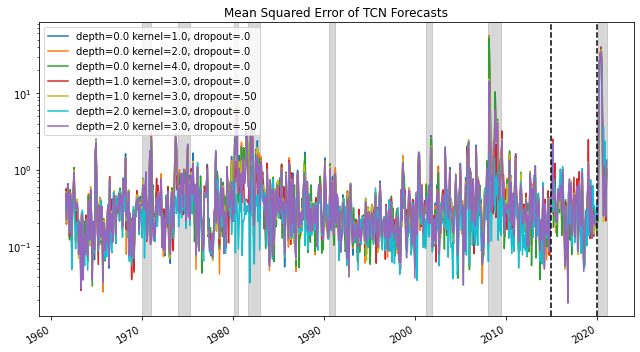

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
ax.set_yscale('log')
legend = []
for col, (modelname, parm) in enumerate(res.iterrows()):
    if parm['dropout'] in [0.0, 0.5]:
        tcn_error[modelname].plot(ax=ax, c=f'C{col}', ls='-')
        legend.append(f"depth={parm['blocks']} kernel={parm['kernel_size']}, "
                      f"dropout=.{100*parm['dropout']:.0f}")
for a,b in vspans:
    if a >= train_index[maxlags]:
        ax.axvspan(a, min(b, max(test2_index)), alpha=0.3, color='grey')
ax.set_title('Mean Squared Error of TCN Forecasts')
ax.axvline(max(train_index), color='black', linestyle='--')
ax.axvline(max(test1_index), color='black', linestyle='--')
ax.legend(legend, loc='upper left')
plt.tight_layout()
#plt.savefig(os.path.join(imgdir, 'tcnmse.jpg'))
plt.show()

## Display train and test error of TCN models by dropout and depth parameters
- Train errors decreasing by blocks and increasing by dropout
- Test errors increasing by blocks and decreasing by dropout 

In [25]:
res[res['blocks'].eq(0)]\
    .rename(columns={s+' Error': s for s in ['Train','Test1','Test2']})\
    .pivot(index=['kernel_size'], columns=['blocks']).drop(columns=['dropout'])\
    .swaplevel(0, 1, 1).round(4).sort_index(axis=1)

blocks            0                
              Test1   Test2   Train
kernel_size                        
1            0.3316  2.8639  0.6543
2            0.3096  2.8832  0.6103
4            0.3009  3.0759  0.5735

In [26]:
res[res['blocks'].gt(0)]\
    .rename(columns={s+' Error': s for s in ['Train','Test1','Test2']})\
    .pivot(index=['dropout'], columns=['blocks']).drop(columns=['kernel_size'])\
    .swaplevel(0, 1, 1).round(4).sort_index(axis=1)

blocks        1                       2                
          Test1   Test2   Train   Test1   Test2   Train
dropout                                                
0.0      0.4013  3.6451  0.4179  0.3552  3.1891  0.3015
0.1      0.3671  3.3364  0.4233  0.4024  3.1510  0.3689
0.2      0.3588  3.0303  0.4526  0.4417  4.1451  0.4225
0.3      0.3724  3.0132  0.4647  0.3987  3.2023  0.4441
0.4      0.3569  2.7241  0.4810  0.3592  3.0008  0.4466
0.5      0.3497  2.7997  0.5264  0.3570  2.7928  0.4997

## Plot Train and Test Error of TCN Models

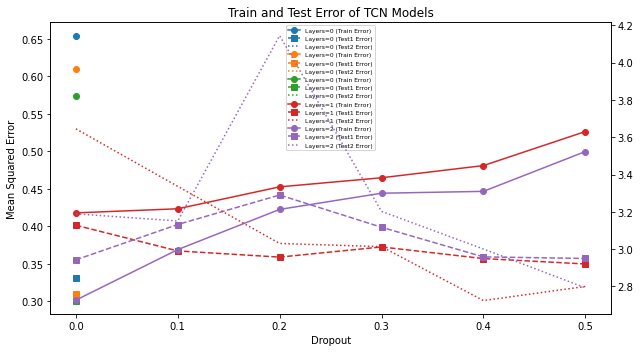

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
bx = ax.twinx()
col = 0
for block in np.unique(res.blocks):
    select_block = res['blocks'].eq(block)
    for kernel_size in np.unique(res['kernel_size'][select_block]):
        select = res['blocks'].eq(block) & res['kernel_size'].eq(kernel_size)

        Series(index=res['dropout'][select], 
               data=res['Train Error'][select].values,
               name=f"Layers={block:.0f} (Train Error)")\
               .plot(ax=ax, color=f"C{col}", style='-', marker='o')
        Series(index=res['dropout'][select], 
               data=res['Test1 Error'][select].values,
               name=f"Layers={block:.0f} (Test1 Error)")\
               .plot(ax=ax, color=f"C{col}", style='--', marker='s')
        ax.plot([],[], color=f"C{col}", ls=':',
                label=f"Layers={block:.0f} (Test2 Error)")
        Series(index=res['dropout'][select], 
               data=res['Test2 Error'][select].values)\
               .plot(ax=bx, color=f"C{col}", style=':')
        col = col + 1    
ax.set_title('Train and Test Error of TCN Models')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Dropout')
ax.legend(loc='upper center', fontsize=6)
plt.tight_layout()
#plt.savefig(os.path.join(imgdir, 'tcn.jpg'))
plt.show()